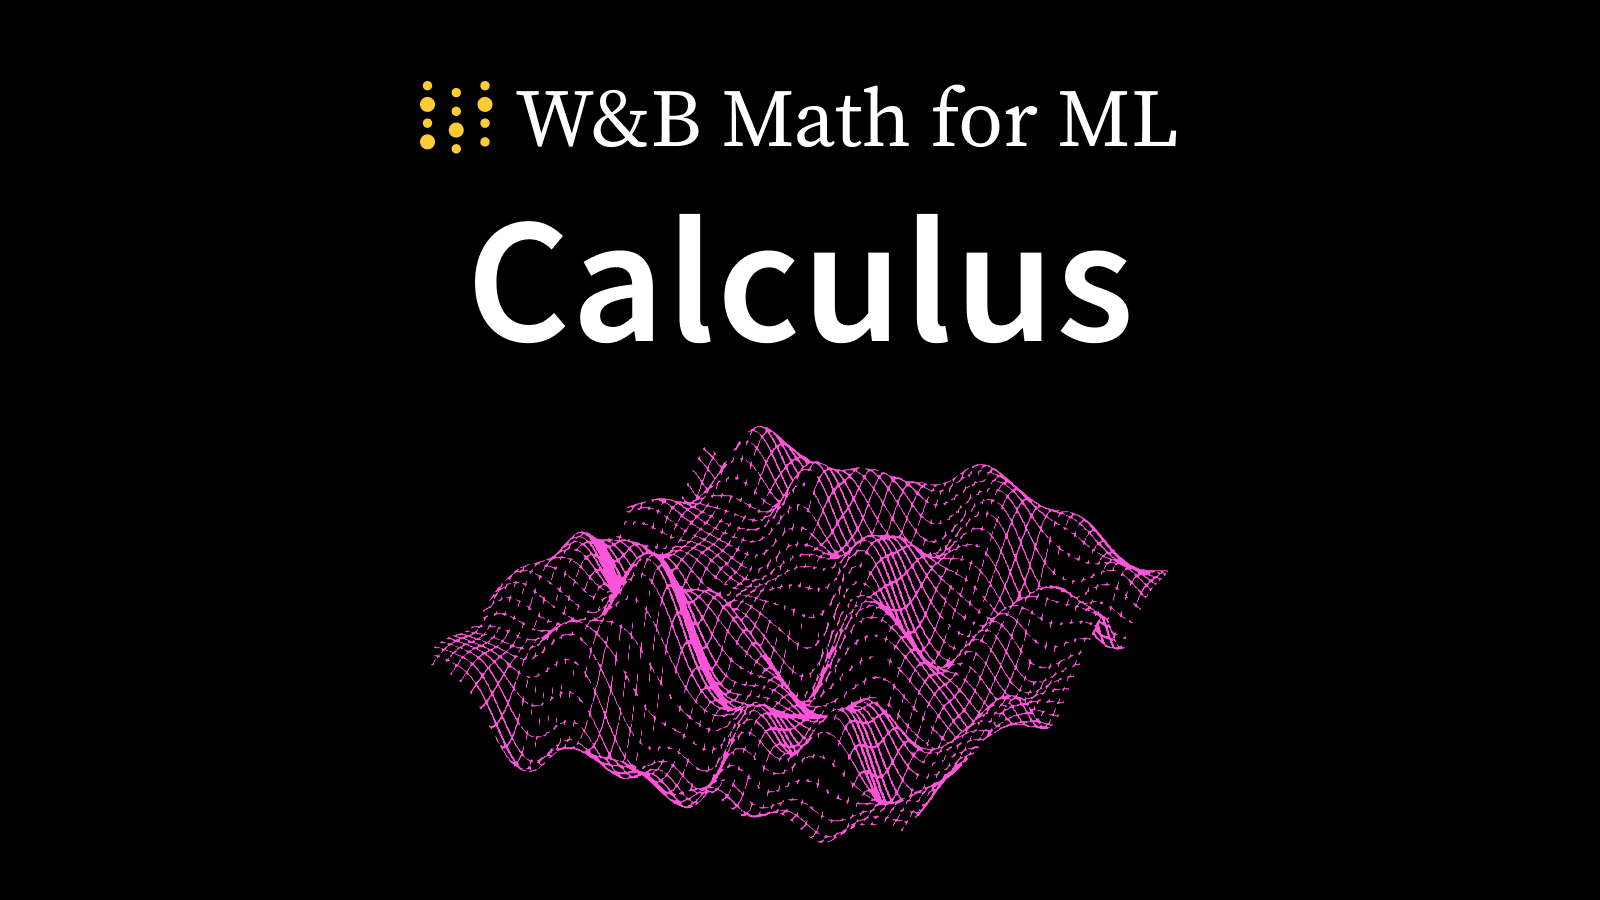

# Extras

## Setup Code

This section includes setup code for the remaining sections.

In [ ]:
%%capture

if "google.colab" in str(get_ipython()):
    %cd "/content/"
    !git clone "https://github.com/wandb/edu.git"
    %cd "edu/math-for-ml"
    !pip install --upgrade -r requirements-colab.txt
    %cd "02_calculus"
else:
    pass

# allows interactive plotting
%matplotlib widget

# importing from standard library
import logging
import os
import random
import sys

# importing libraries
import autograd
import autograd.numpy as np  # trick for automatic differentiation with numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchviz import make_dot as make_graph
import wandb

if "../" not in sys.path:
    sys.path.append("../")

# importing course-specific modules
import autograder
import utils

In [ ]:
def cleanup_models():
    wandb.join()
    model_names = ["linear_model", "nonlinear_model"]
    for model_name in model_names:
        if model_name in globals():
            utils.models.cleanup(eval(model_name))
            
def silence_wandb():
    logger = logging.getLogger("wandb")
    logger.setLevel(logging.ERROR)
    
silence_wandb()
os.environ['WANDB_SILENT'] = 'true'

# Derivatives and Optimization: Interactive Visualizations

## Visualizing the Gradient as an Approximation

The gradient of $f$ is defined as a function, $\nabla f$,
that, given an array $x$, returns an array of the same dimension and shape
(scalar/vector/matrix/tensor, as appropriate)
that can be used to define the best linear approximation to $f$ near the point $x$, as follows:

$$
\hat{f}_x(\varepsilon) =  f(x) + \langle\nabla f(x), \varepsilon\rangle
$$

where the definition of the gradient guarantees

$$
f(x + \varepsilon) = \hat{f}_x(\varepsilon) + o(\|\varepsilon\|).
$$

In this section, we'll visualize this pair of functions,
adjusting the values of $x$ and $\varepsilon$
and observing the behavior of the linear approximation given by the gradient
and the error of the approximation.

The cell below first defines a few functions in `numpy`.
You're welcome to define your own,
simply tacking them onto the end of the list below.
Thanks to the magic of automatic differentiation,
just about any function implemented in `numpy`
that takes in one number and returns one number
will work: `np.sin`, `np.power`, etc.

The following cell then creates an interactive plot for comparing the gradient-based linear approximation to the original function.

A full description of the plot follows below.

In [ ]:
funcs = [lambda xs: np.cos(np.pi * xs),
         lambda xs: np.exp(xs),
         lambda xs: np.square(xs),
         lambda xs: np.abs(xs),
         lambda xs: np.where(xs > 0, xs, 0),
         lambda xs: np.arctan(5 * xs)
        ]

In [ ]:
f = funcs[0]  # pick a function to visualize
interactor = utils.grad_plot.setup(f,)
interactor();

The sliders allow you to independently adjust two parameters: $x$ (represented by a dark gray circle) and $x+\varepsilon$ (light red circle). The plot then updates to display the approximation of $f$ given by the gradient at $x$ ($\hat{f}$, gold line) and the error (vertical purple bar) between that approximation at $\varepsilon$ and the true value: $\hat{f}_x(\varepsilon) - f(x + \varepsilon)$. The value of $\varepsilon$ is represented by a horizontal blue bar. 

For small differences $\varepsilon$, the error and $\varepsilon$ may not be visible.

You should take some time to play with this visualization
applied to the functions at `0`, `1`, and `2` before proceeding.

We begin the questions `funcs[0]`, `cos`ine.

#### Q For `funcs[0]`, the starting point is a maximum of the function. What impact does this have on the approximation given by the gradient?

For the same function, adjust $x$ to a minimum of the function.

#### Q Does the gradient look the same or different?

In gradient descent, we add a negative number times value of the gradient to the current point to obtain the next point.

#### Q What would gradient descent do at each of the points tested above? Does this surprise you?

Still on `funcs[0]`, search for a point where the approximation given by the gradient is as close as possible to the true function. 

#### Q What do you notice about the function at this point?

Switch to `funcs[1]`: the `exp`onential function.

#### Q Which do you predict will have a larger error for $x+\varepsilon = 0$: an approximation based on the gradient at $x=0.5$ or $x=-0.5$?

Check your answer. Hint: you can click the numbers next to the sliders and type in a specific value.

#### Q Try to formulate a theory of when the approximation based on the gradient will be good, in terms of the shape of the original function.

Compare the behavior of the gradients of `funcs[2]`, the `square` of $x$, with `funcs[3]`, the `abs`olute value.

#### Q At all points away from $0$, which of the two functions is better approximated by its gradient?

#### Q What happens at $0$? Can you articulate why?

You might also wish to check out `funcs[4]` while answering these questions.

Interestingly, `autograd` (and just about every automatic differentiation package)
will return a value at $0$ for `funcs[3]` and `[4]`,
even though mathematically the gradient is not defined there.

This is because differentiation packages actually work with a slightly more generalized idea,
[subderivatives](https://en.wikipedia.org/wiki/Subderivative).
This will almost never matter, except that it makes most numerical algorithms "do the right thing" even when they are applied to gnarly functions that don't have gradients everywhere.

#### Q Relate your answers to your theory about when gradients make good approximations. If need be, update your theory!

Finally, return to `funcs[0]`.

When a new plot is generated, $x$ and $x+\varepsilon$ are equal ($\varepsilon$ is $0$).

#### Q Use the definition of $o(\varepsilon)$ to explain why the error is $0$. (Hint: what is $o(0)$?)

Change $x$ to `-0.9` and $x + \varepsilon$ to `0.4`.

#### Q How large is the error (by eye)? Explain this in terms of the meaning of $o(\|\varepsilon\|)$. (Hint: is the value $0$ compatible with $o(\varepsilon)$?)

## Optimizing by Hand versus by Gradient Descent

### Linear Models

You can get a better intuitive feel for optimization by doing it yourself!

The following cell will

1. Generate some data and plot a line over it.
1. Make the plot interactive, so you can adjust the slope and intercept ("bias") of the line with a slider.

First, attempt to fit the data by eye: make it so that the line passes through the data.

In [ ]:
num_datapoints = 2500
input_values = np.linspace(-10, 10, num_datapoints)

parameters = utils.models.make_linear_parameters()

cleanup_models()
linear_model = utils.models.LinearModel(input_values, parameters,
                                       use_wandb=True, entity="charlesfrye",
                                       project="calculus",
                                       wandb_path="./utils")

linear_model.plot()

N = 30

w, b = 0.6, 0.5  # slope, intercept
noise_level = 3

xs = np.random.standard_normal(N) * 2.5
ys = [w * x + b + np.random.standard_normal() * noise_level for x in xs]

linear_model.set_data(xs, ys)
linear_model.make_interactive();

Once you've found a fit you like, run the cell below this one. This will now cause the model to print the mean squared error whenever you change the parameters.

In [ ]:
linear_model.show_MSE = True

When we use machine learning to fit models to data, we need objective metrics like mean squared error in order to use mathematical optimization techniques like gradient descent. They are sometimes called objective functions, loss functions, or cost functions.

They don't always match what look like good parameters by eye.

#### Q Wiggle the parameters around a bit (you can do this more finely by clicking one of the sliders and then using the arrow keys). Does the MSE increase in any direction?

#### Q Find the MSE-minimizing parameters. Try and articulate the strategy that you used.

The strategy you used need not look like gradient descent.

Reset the parameters back to `0`
(either on your own, or by re-running the figure-generating cell).
Then, execute the cell below (and, if needed, scroll back up) to produce an animation of gradient descent adjusting the parameters of the model.

In [ ]:
linear_model.show_MSE = False
linear_model.run_gd(n=25, delta_t=0.1, lr=5e-3)

You should see the slope and intercept of the line changing in the graph
(the values in the controlling sliders will not change).

#### Q How does the behavior of gradient descent differ from your strategy for minimizing the error?

### Non-Linear Models

The cell below repeats the process above for one of two different nonlinear models.

First, run the cell as is and fit the data by hand. Feel free to use the MSE to guide your optimization.
Then, run the cell beneath it to run gradient descent on the model.

In [ ]:
theta_range = [-10, 10]
input_values, parameters, transform = utils.models.setup_rectlin(theta_range=theta_range)

# theta_range = [-6, 6]
# input_values, parameters, transform = utils.models.setup_trig(np.sin, theta_range=theta_range)

cleanup_models()
nonlinear_model = utils.models.NonlinearModel(input_values, parameters, transform,
                                             use_wandb=True, entity="charlesfrye", project="calculus",
                                             wandb_path="./utils")

N = 300
theta = 2.1
noise_level = 0.75

xs = np.random.standard_normal(N) * 2

ys = transform(theta, xs) + np.random.standard_normal(N) * noise_level

nonlinear_model.plot()
nonlinear_model.show_MSE = True
nonlinear_model.set_data(xs, ys)
nonlinear_model.make_interactive()

In [ ]:
nonlinear_model.show_MSE = False
nonlinear_model.run_gd()

Set the value of `theta` to `6`
(either using the sliders or by hand)
and then execute the cell ending in the call to `run_gd()`.

#### Q What happens? Does gradient descent successfully reduce the model error?

The code cell below will plot the error as a function of `theta` for the model you most recently ran above. This is the loss function for this model, the function we would like to optimize.

#### Q Explain the behavior of gradient descent on this model. In your answer, try to make reference to the definition of the gradient.

In [ ]:
plt.figure()
thetas = np.linspace(*theta_range, num=500)
plt.plot(thetas, [np.mean(np.square(ys - transform(theta, xs))) for theta in thetas], lw=3);
plt.xlabel("theta", fontsize="x-large"); plt.ylabel("MSE loss", fontsize="x-large");

Once you have completed the above questions for the `rect`ified `lin`ear model,
comment out the first two lines and
then uncomment the following two lines,
which will set up a nonlinear model based on a `trig`onometric function.

Follow all of the instructions again for this new dataset and model:
fit the model by hand and with gradient descent,
then answer the questions again.

Compare and contrast the behavior of gradient descent on these two problems.
Use the shape of the loss function, from the cell above,
to aid in your answer.

## Gradient Descent on Loss Surfaces

In general, machine learning models depend on more than one parameter,
and so to understand the behavior of gradient descent,
we need to consider loss functions with multiple input dimensions,
also known as loss *surfaces*.

To draw a loss surface, we plot the value of the loss function at each combination of values for the inputs. Because we're able to, at most, make things in 3 dimensions, we'll have two input dimensions and leave the third for the loss.

A surface is one way to generalize the familiar old idea of the graph of a function to functions that take more than one input.

We live on a surface of this type, the surface of the Earth. If you want to think of it as a loss function, you could think of it as the loss function you'd have if you didn't like being at a high altitude, as a function of your latitude and longitude. Consider: what point on Earth would optimize this loss function?

Let's visualize some surfaces that are closer to what you might see if you plotted the loss surface for a machine learning model you were optimizing. A list of loss functions is defined in the cells below, first in Python and then, for some, in mathematical notation.

In [ ]:
scale = 1

losses = [lambda x,y: np.square(x) + np.square(y),
          lambda x,y: np.square(x) + 0.1 * np.square(y),
          lambda x,y: 3 * np.square(x) + 0.1 * np.square(y),
          lambda x,y: np.cos(3 * x) + 0.5 * (np.square(x) + np.square(y) + x),
          lambda x,y: np.cos(3 * x) + np.square(x)+np.square(y),
          lambda x,y: np.where(np.abs(x)+np.abs(y)<0.75,0,np.abs(x)+np.abs(y)-0.75),
          lambda x,y: np.where(x>y+0.25,1.25,y)+np.square(x)+np.square(y),
          lambda x,y: 0.1 * np.random.standard_normal(size=x.shape),
          lambda x,y: utils.surfaces.gauss_random_field(x, y, scale)]

$$
\begin{align}
    l_0(x, y) &= x^2 + y^2\\
    l_1(x, y) &= x^2 + 0.1 \cdot y^2\\
    l_2(x, y) &= 3x^2+ 0.1 \cdot y^2\\
    l_3(x, y) &= \cos(3x) + 0.5 \cdot (x^2 + y^2 + x)\\
    l_4(x, y) &= \cos(3x) + x^2 + y^2\\
    l_5(x, y) &= \left\{\begin{array}{rl}
            \|x\|+ \|y\| - 0.75, & \text{if } \|x\|+ \|y\| > 0.75\\
            0, & \text{otherwise }
            \end{array}\right.\\
    l_6(x, y) &= x^2 +y^2 + \left\{\begin{array}{rl}
            1.25, & \text{if } x > y + 0.25\\
            y, & \text{otherwise }
            \end{array}\right.\\
\end{align}
$$

The next cell produces a 3-D plot of a single loss surface, chosen by indexing into the `losses` list.

In [ ]:
loss = losses[6]

N = 50

mesh_extent = 1.5

utils.surfaces.plot_loss_surface(loss, N, mesh_extent)

The following questions will ask you to visualize these loss surfaces and answer questions about them.

For certain problems, gradient descent performs nicely. View `losses[0]`.

#### Q Pick a few different starting points and follow the direction of steepest descent. Where do you end up?

#### Q What's nice about this loss surface?
*This question might be easier to answer once you've seen some of the other loss surfaces.*

When we follow gradients numerically, using a computer, we have to pick a scale for the "size" of steps we take. This can cause problems we might not anticipate with a view of gradient descent based on physical intuition.

View `losses[1]` and then `losses[2]`.

#### Q Why might picking a size of step cause issues with the surface `losses[1]` or `losses[2]`?

Other problems can't be solved by gradient descent effectively. Select `losses[3]`.

#### Q Again, select multiple different starting points and follow the direction of steepest descent. What's different in this case?

#### Q Why might this change in the behavior of gradient descent be a bad thing?

There are several similar cases to the above issue that are of interest. View `losses[4]` and then `losses[5]`.

#### Q Compare and contrast loss surfaces `3`, `4`, and `5`. Which ones cause issues for optimization? Explain your answers.

Some issues are more theoretical than practical. View `losses[6]`.

#### Q Can we still do gradient descent on this loss surface? Why or why not?

For some loss functions, the right method of minimization can be hard to decide. View `losses[7]`.

On this function, the value at each point is random and independent of the value at all other points.

#### Q What strategies might you use to minimize this loss function?

The loss surfaces for things like "a neural network that maps [pictures of horses to almost identical pictures of zebras](https://github.com/junyanz/CycleGAN)" are expected to be much more complicated than the ones we've looked at so far. The next class of loss functions is a simplified model of a neural network loss.

View `losses[8]` with the parameters `N = 100`, `mesh_extent = 10`, and `scale = 1` in the plotting and loss definition cells (original values are `50`, `1.5`, and `1`, for reference).

You can also attempt to increase these values to `N = 150`, `mesh_extent = 25`, and `scale = 2`. With these settings, the plot will take a bit of time to render on most machines and the plot will lag when interacted with. On some machines, this may consume too much memory and cause the plot to not render. If the plot successfully renders and you'd like to see more, increase the parameters to `N = 250`, `mesh_extent = 50`, and `scale = 3`.

#### Q Do these loss surfaces look like promising candidates for gradient descent? Why or why not?

# Computational Graphs

The first interactive plots above, like much of contemporary machine learning,
relied on automatic differentiation.

The notes below briefly discuss computational graphs,
the core abstraction behind automatic differentiation,
and show how these graphs can be directly visualized in
[`pytorch`](https://torch.org),
a popular library for automatic differentiation focused on deep neural networks.

## Creating and Visualizing Graphs

### Simple Expressions

First, let's consider a very simple expression,
courtesy of an example from Chris Olah's
[blogpost on automatic differentiation](https://colah.github.io/posts/2015-08-Backprop/).

$$
e = (a + b) * (b + 1)
$$

There are two "input variables" here: $a$ and $b$.

To get `torch` to track these values as variables,
not constants, we need to tell it
that we will need their gradient later: `requires_grad` is `True`.

In [ ]:
a = torch.ones(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Once we've done that, we can write out the expression and then use
`torchviz` to view the graph.

In [ ]:
e = (a + b) * (b + 1)

make_graph(e, {"a": a, "b": b})

Every node of the graph is part of the computation of $e$:
either a variable defined above or the result of applying an operation,


The contents and structure of this graph become a bit clearer
if we consider how the value of $e$ is computed.

We might do this mathematically by defining some
intermediate variables.

$$
c = a + b \\
d = b + 1 \\
e = c * d
$$

The cell below defines these variables explicitly.
It also uses some `torch` functions,
like `torch.add`

In [ ]:
a = torch.ones(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

c = torch.add(a, b)
d = torch.add(b, 1)

e = torch.mul(c, d)

make_graph(e, {"a": a, "b": b})

Does the graph change? Why should it, or why should it not?

For both examples, try to map the symbols in the Python code onto the graph.

Do any of the symbols in the Python code fail to show up in the graph?

There's more than one way to calculate the same thing.

Even if the result of the computation is the same,
the graph can look quite different.

That's because the graph captures the _procedure of computation_,
not the result.

For example, $e$ can also be written
$$
e = (a + b) * (b + 1)  = a * b + b * b + a + b
$$

The cell below defines $e$ this way,
then produces a graph.

In [ ]:
a = torch.ones(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

e = a * b + b * b + a + b

make_graph(e, {"a": a, "b": b})

Does the graph look the same or different? Are there more or fewer nodes? What does this imply about which of the ways of calculating $e$ above is faster?

As it turns out, finding ways to shrink the size of computational graphs through refactoring is a core component of fast algorithms from machine learning
(e.g. [belief propagation](https://en.wikipedia.org/wiki/Belief_propagation)
and the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm),
which underlie [error-correcting codes](https://en.wikipedia.org/wiki/Turbo_code#Bayesian_formulation)).

### Examples from Machine Learning

The next section shows the computational graphs for a few machine learning algorithms.

#### Linear Regression

The cell below implements linear regression on two variables predicting a third
(see shapes of `input_data` and `output_data`)
and produces the graph.

The `Addmm` operation combines `Add`ition and `m`atrix `m`ultiplication into a single operation.

In [ ]:
input_data = torch.randn(size=(100, 2))
output_data = torch.randn(size=(100, 1))

bias = torch.randn(1, requires_grad=True)
weight = torch.randn((2, 1), requires_grad=True)

mean_squared_error = ((output_data - torch.addmm(bias, input_data, weight)) ** 2).mean()

make_graph(mean_squared_error, {"bias": bias, "weight": weight})

#### A Barebones Neural Network

The cell below defines a classic neural network,
along with some dummy inputs `x` and targets `y`.

You'll notice that the "head" of the graph,
from `AddmmBackward` to `MeanBackward0`
is identical to that from the linear regression example.

Also, you'll notice that the graph has two repeated parts:
one for the module `W0` and another for the module `W1`.

These are core properties of neural nets:
they are closely related to linear models
and they are constructed of modular pieces.
It is an important feature of computational graphs that these features are easy to see.

In [ ]:
model = nn.Sequential()
model.add_module("W0", nn.Linear(8, 16))
model.add_module("tanh", nn.Tanh())
model.add_module("W1", nn.Linear(16, 1))

x = torch.randn(1, 8)
y = torch.randn(1, 16)
model_output = model(x)
loss = ((model_output - y) ** 2).mean()

make_graph(loss, params=dict(model.named_parameters()))

#### ResNet50: An "Industrial" Neural Network

The following cell sets up a much beefier, famous network:
[ResNet50](https://arxiv.org/abs/1512.03385),
suitable for difficult computer vision tasks in high definition.

This network is extremely large (~23 million parameters),
and so you may find that the visualization below breaks down
(cut off at corners, text too small, etc.).

This example is included to give a sense of what an "industrial"
computational graph looks like.

In [ ]:
resnet = models.resnet50(pretrained=False)

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = resnet(x)

make_graph(out) 

## Automating Calculus with Graphs

The primary use of computational graphs in machine learning is to automate the calculation of gradients.

If each operation has a defined gradient,
we can calculate the gradient of a node $B$ with respect to a node $A$
by two simple rules:

- Add the gradient computed by following each path from $A$ to $B$
- Along each path from $A$ to $B$, multiply the gradients together

In order for this to work, each function must
1. be tracked and added to the graph
2. have a matched "opposite" function that can
3. compute the gradient of its outputs with respect to its inputs.

In `torch`, these properties are guaranteed by
1. defining an object that sub-classes `torch.autograd.Function` and
2. implements a `backward` method that
3. is equal to the gradient of the `forward` method that applies the function.

The lattermost is the responsibility of the programmer to confirm.

The example below shows how this is done with a very simple function that just returns its `inputs`.

So that you can see when the methods are called, they also `print` a friendly message.

In [ ]:
class DummyFunction(torch.autograd.Function):

    # method for the original computation
    @staticmethod
    def forward(ctx, input):
        print("hello from forward!")
        return input

    # method for the gradient computation
    @staticmethod
    def backward(ctx, grad_output):
        print("hello from backward!")
        return grad_output

dummy = DummyFunction.apply

In [ ]:
x = torch.ones(1, requires_grad=True)

a = dummy(x)

make_graph(a)

In [ ]:
torch.autograd.grad(a, x)